### Importing Modules

In [1]:
import pandas as pd
import autocomplete
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import math

In [62]:
# User Defined function
def filtr(lst,itemid):
    if len(lst)==0:
        pass
    elif len(lst)>1 or len(lst)==1:
        lst.remove(itemid)
    return lst

def recommenditems(itemid):
    recommendation={}
    for i in visitor_bought_df['itemid']:
        if itemid in i:
            item_list_bought=[j for j in i]

    also_bought=list(set(item_list_bought))
    also_bought= filtr(also_bought,itemid)
    for i in category_df['itemid']:
        if itemid in i:
            item_list_cat=[j for j in i]
        
    same_category=list(set(item_list_cat))
    same_category=filtr(same_category,itemid)
    recommendation['also_bought']=also_bought
    recommendation['same_category']=same_category
    return recommendation

### Loading Data

In [33]:
dataset1= pd.read_csv("item_properties_part1.csv")
dataset2= pd.read_csv("item_properties_part2.csv")
itemproperties = pd.concat([dataset1,dataset2],ignore_index=True, sort =False)
events = pd.read_csv("events.csv")

### Exploratory Data Analysis

In [8]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [11]:
itemproperties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [10]:
itemproperties.shape, events.shape

((20275902, 4), (2756101, 5))

In [12]:
events['timestamp'] = pd.to_datetime(events.timestamp,unit='ms')
events['timestamp'] = pd.to_datetime(events['timestamp']).dt.date
events = events.sort_values(by='timestamp')


uniquecustomers = events['visitorid'].unique()
listofeventspurchased = events[events['transactionid'].notnull()] 
listofcustomerpurchased = events[events['transactionid'].notnull()].visitorid.unique() 

print("Out of",events['visitorid'].size,"total visitors there are",uniquecustomers.size,
      "unique visitors")

print("Out of",uniquecustomers.size,"unique customers,there are",listofcustomerpurchased.size,
      "customers who actually purchased atleast one item")

notpurchased = uniquecustomers.size - listofcustomerpurchased.size
print("Number of customers who did not purchase anything",notpurchased)

overalleventcounts = events['event'].value_counts()
overalleventcounts = overalleventcounts.to_frame()
overalleventcounts.reset_index(level=0, inplace=True)
overalleventcounts = overalleventcounts.rename(columns={'index':'event','event':'eventcounts'})
overalleventcounts.to_csv('overalleventcounts.csv',index = False)
print(overalleventcounts)

Out of 2756101 total visitors there are 1407580 unique visitors
Out of 1407580 unique customers,there are 11719 customers who actually purchased atleast one item
Number of customers who did not purchase anything 1395861
         event  eventcounts
0         view      2664312
1    addtocart        69332
2  transaction        22457


<Figure size 576x576 with 0 Axes>

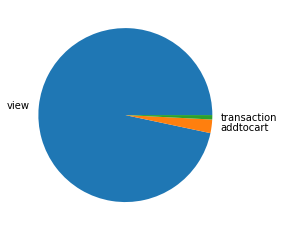

<Figure size 576x576 with 0 Axes>

In [13]:
df_events=pd.DataFrame(events.event.value_counts()*100/len(events))
plt.pie(df_events.values,labels=df_events.index)
plt.figure(figsize=(8,8))

In [15]:
eventandtime = events.iloc[:,[0,2]]
groupbyeventanddate = eventandtime.groupby(['timestamp', 'event']).size()
groupbyeventanddate = groupbyeventanddate.to_frame()
groupbyeventanddate = groupbyeventanddate.add_suffix('_Count').reset_index()
groupbyeventanddate = groupbyeventanddate.rename(columns={'0_Count':'Eventcountsperday'})
groupbyeventanddate.to_csv('eventcountsbydate.csv',index = False)
groupbyeventanddate.head(10)

,timestamp,event,Eventcountsperday
0,2015-05-03,addtocart,296
1,2015-05-03,transaction,83
2,2015-05-03,view,13304
3,2015-05-04,addtocart,579
4,2015-05-04,transaction,154
5,2015-05-04,view,18681
6,2015-05-05,addtocart,565
7,2015-05-05,transaction,225
8,2015-05-05,view,22225
9,2015-05-06,addtocart,647


In [16]:

#groupby timestamp, visitor id and event
eventtimecustomer = events.iloc[:,[0,1,2]]
groupbyeventcustomerdate = eventtimecustomer.groupby(['timestamp', 'visitorid','event']).size()
groupbyeventcustomerdate = groupbyeventcustomerdate.to_frame()
groupbyeventcustomerdate = groupbyeventcustomerdate.add_suffix('').reset_index()
groupbyeventcustomerdate = groupbyeventcustomerdate.rename(columns={'0':'Eventcounts/customer'})
groupbyeventcustomerdate.head(10)

,timestamp,visitorid,event,Eventcounts/customer
0,2015-05-03,12,view,1
1,2015-05-03,385,view,1
2,2015-05-03,1250,view,1
3,2015-05-03,1525,view,1
4,2015-05-03,1701,view,1
5,2015-05-03,1819,view,1
6,2015-05-03,2050,view,1
7,2015-05-03,2231,view,8
8,2015-05-03,2288,view,1
9,2015-05-03,2306,view,1


In [4]:
itempropertiescategorywise = itemproperties[itemproperties['property']=='categoryid']
categoryfreq = itempropertiescategorywise.groupby('property')['itemid'].nunique()
print("Total number of unique items:",categoryfreq['categoryid'])
print("Out of",itempropertiescategorywise.itemid.size, "there are",categoryfreq['categoryid'],"unique items")
categorywiseuniqueitems = pd.DataFrame(itempropertiescategorywise.groupby('value')['itemid'].apply(list))
categorywiseuniqueitems.reset_index(level=0, inplace=True)
catitems = {}
for i in range(len(categorywiseuniqueitems)):
    catitems[categorywiseuniqueitems['value'].iloc[i]] = categorywiseuniqueitems['itemid'][i]

Total number of unique items: 417053
Out of 788214 there are 417053 unique items


In [17]:
user={}
repeatedusers = []
            
for i in range(len(listofeventspurchased)):
    for key,value in catitems.items():
        if listofeventspurchased['itemid'].iloc[i] in catitems[key]:
            if listofeventspurchased['visitorid'].iloc[i] in repeatedusers:
                user[listofeventspurchased['visitorid'].iloc[i]].append(key)
                repeatedusers.append(listofeventspurchased['visitorid'].iloc[i])
            else:
                user[listofeventspurchased['visitorid'].iloc[i]] = key

In [20]:
#list of unique items in category 
category_df=itemproperties.loc[itemproperties['property']=='categoryid'].groupby('value')['itemid'].unique().apply(list)
category_df=pd.DataFrame(category_df)
category_df=category_df.reset_index()
category_df['categoryid']=category_df['value']
category_df.drop('value',axis=1,inplace=True)
category_df['items']=1
for i in range(0,len(category_df.itemid)):
    category_df.at[i,'items']=len(category_df.iloc[i,0])

In [55]:
category_df.head()

,itemid,categoryid,items
0,"[1957, 207072, 347416, 458345, 167416, 123751,...",0,135
1,"[390448, 465859, 211677, 304558, 31165, 25820,...",1,867
2,"[245380, 449019, 26377, 96493]",10,4
3,"[134781, 135974, 291251, 425166, 352564, 38543...",100,10
4,"[269839, 100740, 449301]",1000,3


In [23]:
# list of items bought buy customer 
visitor_bought_df=events.loc[events['event']=='transaction'].groupby('visitorid')['itemid'].apply(list)
visitor_bought_df=pd.DataFrame(visitor_bought_df)
visitor_bought_df=visitor_bought_df.reset_index()
visitor_bought_df['items']=1
for i in range(0,len(visitor_bought_df.itemid)):
    visitor_bought_df.at[i,'items']=len(visitor_bought_df.iloc[i,1])

In [70]:
visitor_bought_df.head(10)

,visitorid,itemid,items
0,172,"[465522, 10034]",2
1,186,[49029],1
2,264,"[459835, 161949]",2
3,419,[19278],1
4,539,[94371],1
5,627,[414182],1
6,795,[207825],1
7,914,[382946],1
8,964,[430113],1
9,1032,[243949],1


In [69]:
recommenditems(312728)

{'also_bought': [73123, 282820, 90660, 409804, 328476],
 'same_category': [59395,
  329732,
  16390,
  428044,
  73741,
  378900,
  333846,
  147479,
  337951,
  10271,
  321567,
  241703,
  356396,
  217132,
  131119,
  389172,
  49205,
  346168,
  309305,
  124994,
  258116,
  90191,
  307286,
  440413,
  327777,
  421987,
  374883,
  456820,
  417912,
  190590,
  340094,
  252034,
  307331,
  305286,
  225418,
  327820,
  170126,
  321681,
  80017,
  354453,
  340122,
  327838,
  55455,
  118945,
  135329,
  383137,
  22692,
  135338,
  415932,
  82109,
  417981,
  420030,
  168146,
  428246,
  4312,
  178392,
  338138,
  405728,
  135393,
  162019,
  121067,
  59628,
  12525,
  327929,
  67834,
  137471,
  323846,
  98567,
  24842,
  221453,
  403729,
  246033,
  139539,
  286995,
  344339,
  84245,
  248087,
  22809,
  174366,
  229662,
  31008,
  20768,
  166182,
  147765,
  323894,
  442678,
  170296,
  137529,
  221499,
  295229,
  272709,
  92488,
  461138,
  237907,
  237916,

In [73]:
events.transactionid.isna().sum()

2733644

In [74]:
events.shape

(2756101, 5)

In [75]:
2756101-2733644

22457

### Modeling

In [145]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix

In [ ]:



def objective(params):
    # unpack
    epochs, learning_rate, no_components = params

    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)

    patks = auc_score(model, test, num_threads=4)
    maptk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -maptk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out



space = [(1, 40), # epochs
         (10**-4, 0.5, 'log-uniform'), # learning_rate
         (20, 200), # no_components
        ]

res_fm = forest_minimize(objective, space, n_calls=20,
                     random_state=0,
                     verbose=True)
print('Maximimum auc found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

In [68]:
events=events[events['event']!='view']
events['rating'] = np.where(events['event']=='transaction', 1, 0)

In [69]:
event_trans=events[['visitorid','itemid','rating']]

In [70]:
event_train, event_test=train_test_split(event_trans,test_size=0.3)

In [71]:
event_test=event_test[(event_test['visitorid'].isin(event_train['visitorid'])) & (event_test['itemid'].isin(event_train['itemid']))]

In [72]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(event_train[k].values)
    trans_cat_test[k]=cate_enc.transform(event_test[k].values)

In [104]:
ratings['train'] = event_train['rating']
ratings['test'] = event_test['rating']
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [106]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], (trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users,n_items))
    

In [86]:
rate_matrix['train'].toarray().shape

(31032, 21076)

In [132]:
model = LightFM(no_components=2, loss='bpr')
model.fit(rate_matrix['train'], epochs=150, num_threads=8)

In [144]:
count=0
iteration=[]
auc=[]
for components in [2,4,10,110]:
    for loss in ['logistic', 'bpr', 'warp', 'warp-kos']:
        for lr in [0.03,0.1,0.4]:
            model = LightFM(no_components=components, loss=loss, learning_rate=lr)
            model.fit(rate_matrix['train'], epochs=10, num_threads=8)
            score=auc_score(model, rate_matrix['train'], num_threads=8).mean()
            auc.append(score)
            iteration.append(count)
            count+=1       

In [148]:
auc.index(max(auc))

46

In [151]:
count=0
best_estimator=[]
for components in [2,4,10,110]:
    for loss in ['logistic', 'bpr', 'warp', 'warp-kos']:
        for lr in [0.03,0.1,0.4]:
            if count==46:
                best_estimator.append(components)
                best_estimator.append(loss)
                best_estimator.append(lr)
                break
            count+=1
            

In [153]:
print ('n_components :', best_estimator[0])
print ('loss_function :',best_estimator[1])
print ('Learning rate :',best_estimator[2])

n_components : 110
loss_function : warp-kos
Learning rate : 0.1


In [141]:
auc_score(model, rate_matrix['train'], num_threads=8).mean()

0.5622569

In [113]:
auc_score(model, rate_matrix['test'], num_threads=8).mean()

0.61679024

In [140]:
precision_at_k(model,rate_matrix['train'],k=1).mean()

0.0026424336

In [154]:
#traditional collaborative filtering matrix factorization method
model_best = LightFM(no_components=110, loss='warp-kos')
model_best.fit(rate_matrix['train'], epochs=10, num_threads=8)

In [155]:
auc_score(model_best, rate_matrix['train'], num_threads=8).mean()

0.9984754

In [156]:
auc_score(model_best, rate_matrix['test'], num_threads=8).mean()

0.900335

In [163]:
precision_at_k(model_best,rate_matrix['train'],k=2).shape

(31032,)

In [160]:
precision_at_k(model_best,rate_matrix['test'],k=2).mean()

0.2918725